In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [15]:
hue_order = ["bind-9.11.3", "unbound-1.16.0", "unbound-1.10.0", "powerDNS-4.7.3"]

<AxesSubplot:title={'center':'Subquery'}, xlabel='NS Delegations', ylabel='# of client queries'>

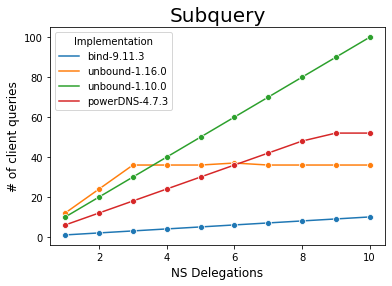

In [18]:
df_results = pd.read_csv("subquery.csv")
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Subquery", fontsize = 20)
ax.set_xlabel("NS Delegations", fontsize = 12)
ax.set_ylabel("# of client queries", fontsize = 12)
sns.lineplot(x="NS Delegations", y="Amplification", hue="Implementation", hue_order=hue_order, data=df_results, marker="o", ax=ax)

<AxesSubplot:title={'center':'Subquery+CNAME'}, xlabel='NS Delegations', ylabel='# of client queries'>

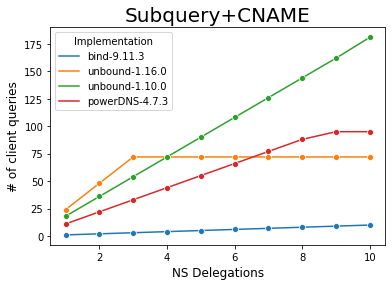

In [19]:
df_results = pd.read_csv("subquery+CNAME.csv")
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Subquery+CNAME", fontsize = 20)
ax.set_xlabel("NS Delegations", fontsize = 12)
ax.set_ylabel("# of client queries", fontsize = 12)
sns.lineplot(x="NS Delegations", y="Amplification", hue="Implementation", hue_order=hue_order, data=df_results, marker="o", ax=ax)

<AxesSubplot:title={'center':'Subquery+CNAME+QMIN'}, xlabel='NS Delegations', ylabel='# of client queries'>

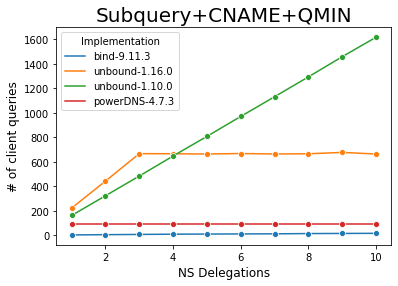

In [20]:
df_results = pd.read_csv("subquery+CNAME+QMIN.csv")
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Subquery+CNAME+QMIN", fontsize = 20)
ax.set_xlabel("NS Delegations", fontsize = 12)
ax.set_ylabel("# of client queries", fontsize = 12)
sns.lineplot(x="NS Delegations", y="Amplification", hue="Implementation", hue_order=hue_order, data=df_results, marker="o", ax=ax)

In [ ]:
def create_combined_plots_simple(list_list_values, filename, implementation_names, folder_path):

    x = range(1, len(list_list_values[0])+1)
    fig = plt.figure()
    ax = fig.add_subplot()

    missing_attributes = []
    ns_del = 0
    cname_chain_length= 0
    nb_labels = 0

    x_labels = "TOBEDEFINED"

    ax.set_xlabel(x_labels, fontsize = 12)
    ax.set_ylabel('Amplification factor', fontsize = 12)

    ax.set_xlim(0,10+1)
    ax.set_ylim(0, 1700)

    fixed_vars = {"ns_del" : "#Del={}".format(str(ns_del)), "cname_chain_length" : "CNAME_length={}".format(str(cname_chain_length)), "nb_labels" : "#Labels={}".format(str(nb_labels))}
    fixed = [fixed_vars[i] for i in fixed_vars.keys()]
    vars = ", ".join(fixed)
    # RElated to the previous : find from the filename what are the fixed attributes
    ax.set_title('Amplification factor c/nameserver with Sub+CCV+QMIN \n Fixed values : {vars}'.format(vars=vars), fontsize = 11)

    ax.grid()
    for list_values in list_list_values:
        ax.plot(x, list_values, marker = 'o')


    plot_path = folder_path+"fig_"+filename.split(".")[0]+".jpg"
    
    # remove the previous path
    if os.path.exists(plot_path):
        os.remove(plot_path)
        #print("removed plot")
        
    

    for i in range(0,len(implementation_names)):
        list_values = list_list_values[i]
        max_point_annot(x,list_values, implementation_names[i], i/len(list_list_values))

    plt.legend(implementation_names)

    plt.savefig(plot_path)
    plt.close()
